# Credit Card Application Scoring: Performance & Business Impact 

### This notebook implements a Logistic Regression model from scratch (IRLS) to predict credit card approvals and optimizes the decision threshold based on business costs.

In [1]:
# 1) Imports & global settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Data splitting and validation tools
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# Performance and calibration metrics
from sklearn.metrics import (
    brier_score_loss, roc_auc_score, average_precision_score,
    classification_report, confusion_matrix, roc_curve, roc_auc_score
)
from sklearn.calibration import calibration_curve


# Global seed and business parameters
RANDOM_STATE = 22
np.random.seed(RANDOM_STATE)

COST_FP, COST_FN = 5, 1
THR_BUSINESS = 0.85
THRESHOLDS = np.arange(0.10, 0.91, 0.05)

## 1. Data Preparation 
We load the dataset, handle missing values, and encode categorical variables. The features are then standardized to ensure the stability of the IRLS algorithm.

In [2]:
# 2) Load data & preprocessing
df = pd.read_csv("CreditCard.csv")
print(f"Dataset shape: {df.shape}")
print(df.head())

# Check and handle missing values for selected columns
used_cols = ["card","reports","age","income","owner","selfemp","dependents","months","majorcards","active"]
missing = df[used_cols].isna().sum()
missing_tot = int(missing.sum())

if missing_tot > 0:
    print(f"Missing values (total): {missing_tot}")
    print(missing[missing > 0].sort_values(ascending=False).to_string())
    n0 = len(df)
    df = df.dropna(subset=used_cols).copy()
    print(f"Dropped rows: {n0 - len(df)} | New shape: {df.shape}")
else:
    print("Missing values: 0")

# Encoding target and binary features
df["y"] = (df["card"] == "yes").astype(int)
df["owner_bin"] = (df["owner"] == "yes").astype(int)
df["selfemp_bin"] = (df["selfemp"] == "yes").astype(int)

feature_cols = ["reports","age","income","owner_bin","selfemp_bin","dependents","months","majorcards","active"]
covariate_names = ["intercept","reports","age","income","owner","selfemp","dependents","months","majorcards","active"]

y = df["y"].to_numpy()
X_raw = df[feature_cols].to_numpy()

# Stratified split to maintain class balance
idx = np.arange(len(y))
idx_tr, idx_te = train_test_split(idx, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

X_raw_tr, X_raw_te = X_raw[idx_tr], X_raw[idx_te]
y_tr, y_te = y[idx_tr], y[idx_te]

# Standardization based on training statistics
mu = X_raw_tr.mean(axis=0)
sd = X_raw_tr.std(axis=0, ddof=0)
sd_safe = np.where(sd == 0, 1.0, sd)

# Add intercept to the standardized features
X_tr = np.column_stack([np.ones(len(X_raw_tr)), (X_raw_tr - mu) / sd_safe])
X_te = np.column_stack([np.ones(len(X_raw_te)), (X_raw_te - mu) / sd_safe])

# Define main sets for downstream modeling
X_tr_main, X_te_main = X_tr, X_te
y_tr_main, y_te_main = y_tr, y_te

print(f"Train/Test: {len(y_tr_main)}/{len(y_te_main)} | "
      f"Prevalence: {y_tr_main.mean():.3f}/{y_te_main.mean():.3f}")

Dataset shape: (1319, 12)
  card  reports       age  income     share  expenditure owner selfemp  \
0  yes        0  37.66667  4.5200  0.033270   124.983300   yes      no   
1  yes        0  33.25000  2.4200  0.005217     9.854167    no      no   
2  yes        0  33.66667  4.5000  0.004156    15.000000   yes      no   
3  yes        0  30.50000  2.5400  0.065214   137.869200    no      no   
4  yes        0  32.16667  9.7867  0.067051   546.503300   yes      no   

   dependents  months  majorcards  active  
0           3      54           1      12  
1           3      34           1      13  
2           4      58           1       5  
3           0      25           1       7  
4           2      64           1       5  
Missing values: 0
Train/Test: 1055/264 | Prevalence: 0.775/0.777


### Target Variable Exploration
Visualizing the balance between approved and rejected applications to understand the baseline prevalence

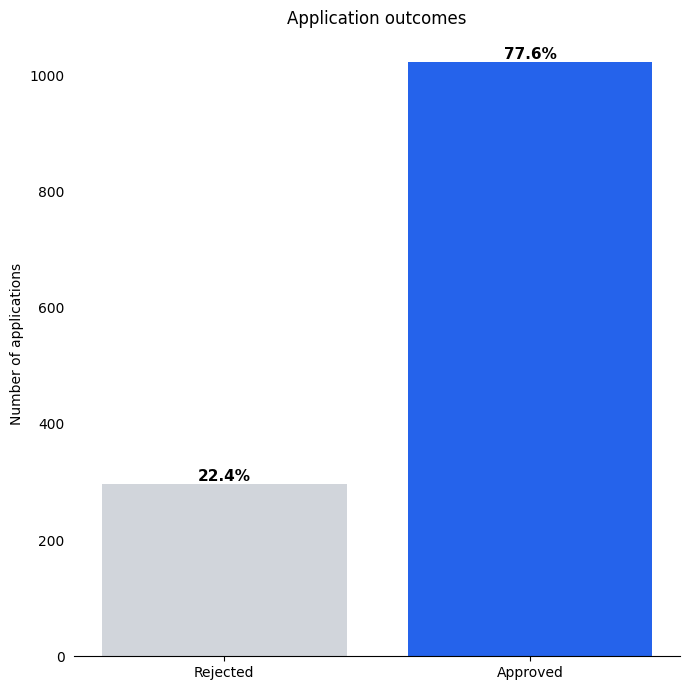

In [3]:
# 3) Target distribution visualization
counts = df["y"].value_counts().sort_index()
labels = ["Rejected", "Approved"]
values = [counts[0], counts[1]]
total = sum(values)

colors = ["#D1D5DB", "#2563EB"]  # light gray, muted blue

# Initialize plot
plt.figure(figsize=(7, 7))
bars = plt.bar(labels, values, color=colors)

# Clean up chart aesthetics
ax = plt.gca()
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)
ax.tick_params(left=False)

plt.ylabel("Number of applications")
plt.title("Application outcomes")

# Add percentage labels on top of bars
for bar, v in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{v / total:.1%}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()

## 2. Model Implementation: 
Logistic Regression via IRLS Instead of using standard libraries, we implement the Maximum Likelihood Estimation (MLE) using the Iteratively Reweighted Least Squares (IRLS) algorithm.

In [4]:
# 4) Logistic Regression via IRLS
def sigmoid(z: np.ndarray) -> np.ndarray:
    """Numerically stable sigmoid function."""
    return 1.0 / (1.0 + np.exp(-np.clip(z, -35, 35)))

def fit_logit_irls(X: np.ndarray, y: np.ndarray, tol: float = 1e-8, max_iter: int = 200):
    """
    Logistic regression MLE using Iteratively Reweighted Least Squares (IRLS).
    """
    n, p = X.shape
    beta = np.zeros(p)
    y = y.astype(float)

    for _ in range(max_iter):
        eta = X @ beta
        p_hat = sigmoid(eta)

        # Calculate diagonal weights and adjusted dependent variable
        W = np.clip(p_hat * (1.0 - p_hat), 1e-12, None)
        z = eta + (y - p_hat) / W

        # Solve weighted least squares system
        XtW = X.T * W
        XtWX = XtW @ X
        XtWz = XtW @ z

        beta_new = np.linalg.solve(XtWX, XtWz)

        # Check for convergence
        if np.linalg.norm(beta_new - beta) / (np.linalg.norm(beta) + 1e-12) < tol:
            beta = beta_new
            break
        beta = beta_new

    return beta, W

# Fit model on training data
b_hat, W_hat = fit_logit_irls(X_tr_main, y_tr_main, tol=1e-8, max_iter=200)

# Generate predictions on test set
p_te = sigmoid(X_te_main @ b_hat)

# Display coefficients and prediction summary
beta_s = pd.Series(b_hat, index=covariate_names).round(3)
print("beta:\n" + beta_s.to_string())
print(f"p_test min/mean/max: {p_te.min():.4f} {p_te.mean():.4f} {p_te.max():.4f}")

beta:
intercept     1.460
reports      -2.432
age          -0.105
income        0.395
owner         0.306
selfemp      -0.141
dependents   -0.397
months        0.010
majorcards    0.256
active        0.797
p_test min/mean/max: 0.0000 0.7782 0.9937


## 3. Statistical Interpretation 
We analyze the model coefficients and calculate Odds Ratios with 95% Wald Confidence Intervals to identify the primary drivers of approval.

In [5]:
# 5) Drivers: Odds Ratios and Wald Confidence Intervals
beta = b_hat.reshape(-1)
coef = pd.Series(beta, index=covariate_names)

# Convert standardized coefficients to Odds Ratios (excluding intercept)
coef_no_int = coef.drop("intercept")
or_all = np.exp(coef_no_int)

# Identify top 5 drivers by absolute magnitude
top_k = 5
top_idx = coef_no_int.abs().sort_values(ascending=False).head(top_k).index
top_table = pd.DataFrame({
    "beta": coef_no_int.loc[top_idx],
    "OR":   or_all.loc[top_idx]
}).round(3)

print("\nTop drivers (by |beta|, standardized):")
print(top_table.to_string())

print("\nAll odds ratios (standardized):")
print(or_all.round(3).to_string())

# Calculate Wald standard errors using final IRLS weights from training
XtW = X_tr_main.T * W_hat
XtWX = XtW @ X_tr_main
V = np.linalg.inv(XtWX)
se = np.sqrt(np.diag(V))

# Compute 95% Confidence Intervals
z = 1.96
lo = beta - z * se
hi = beta + z * se

mle = pd.DataFrame({
    "beta": beta,
    "se": se,
    "lo": lo,
    "hi": hi
}, index=covariate_names).drop(index="intercept")

# Transform beta CI limits to Odds Ratio scale
mle["OR"] = np.exp(mle["beta"])
mle["OR_lo"] = np.exp(mle["lo"])
mle["OR_hi"] = np.exp(mle["hi"])

print("\nWald 95% CI (train):")
print(mle.round(3).to_string())


Top drivers (by |beta|, standardized):
             beta     OR
reports    -2.432  0.088
active      0.797  2.218
dependents -0.397  0.672
income      0.395  1.484
owner       0.306  1.358

All odds ratios (standardized):
reports       0.088
age           0.900
income        1.484
owner         1.358
selfemp       0.869
dependents    0.672
months        1.010
majorcards    1.292
active        2.218

Wald 95% CI (train):
             beta     se     lo     hi     OR  OR_lo  OR_hi
reports    -2.432  0.223 -2.870 -1.995  0.088  0.057  0.136
age        -0.105  0.112 -0.324  0.114  0.900  0.723  1.121
income      0.395  0.123  0.154  0.635  1.484  1.166  1.887
owner       0.306  0.114  0.083  0.529  1.358  1.087  1.698
selfemp    -0.141  0.084 -0.306  0.025  0.869  0.736  1.025
dependents -0.397  0.095 -0.584 -0.210  0.672  0.557  0.810
months      0.010  0.103 -0.191  0.212  1.010  0.826  1.236
majorcards  0.256  0.081  0.097  0.415  1.292  1.101  1.515
active      0.797  0.133  0.536  1.

## 4. Evaluation Framework: From Accuracy to Business Cost 
Standard metrics like accuracy are often insufficient for credit scoring. We define a framework to evaluate the model based on asymmetric costs (False Positives vs. False Negatives).

In [6]:
# 6) Policy utilities for threshold evaluation
def eval_threshold(y_true, p, thr, cost_fp=COST_FP, cost_fn=COST_FN):
    """Evaluate a specific threshold policy yhat = 1[p >= thr]."""
    yhat = (p >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yhat).ravel()

    # Calculate operational metrics
    approval_rate = yhat.mean()
    precision = tp/(tp+fp) if (tp+fp) else np.nan
    recall = tp/(tp+fn) if (tp+fn) else np.nan
    specificity = tn/(tn+fp) if (tn+fp) else np.nan

    # Calculate costs based on asymmetric weights
    cost = cost_fp*fp + cost_fn*fn
    cost_per_1000 = 1000*cost/len(y_true)

    return {
        "thr": thr,
        "approval_rate": approval_rate,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        "precision": precision, "recall": recall, "specificity": specificity,
        "cost": cost, "cost_per_1000": cost_per_1000
    }

def build_policy_table(y_true, p, thresholds=THRESHOLDS, cost_fp=COST_FP, cost_fn=COST_FN):
    """Scan thresholds to find the one minimizing business cost."""
    rows = [eval_threshold(y_true, p, t, cost_fp, cost_fn) for t in thresholds]
    tab = pd.DataFrame(rows).sort_values("thr").reset_index(drop=True)
    best = tab.loc[tab["cost_per_1000"].idxmin()].to_dict()
    return tab, best

def print_cm(y_true, yhat, title: str):
    """Helper to display formatted confusion matrix."""
    cm = confusion_matrix(y_true, yhat)
    cm_df = pd.DataFrame(cm, index=["true0", "true1"], columns=["pred0", "pred1"])
    print(f"\n{title}\n{cm_df.to_string()}")
    return cm

def summarize_at_threshold(y_true, p, thr: float):
    """Detailed summary of model performance at a chosen threshold."""
    yhat = (p >= thr).astype(int)
    cm = print_cm(y_true, yhat, title=f"Confusion matrix @ thr={thr:.2f}")
    tn, fp, fn, tp = cm.ravel()

    # Derived rates and metrics
    precision = tp/(tp+fp) if (tp+fp) else np.nan
    recall    = tp/(tp+fn) if (tp+fn) else np.nan
    spec      = tn/(tn+fp) if (tn+fp) else np.nan
    fp_rate   = fp/(fp+tn) if (fp+tn) else np.nan
    fn_rate   = fn/(fn+tp) if (fn+tp) else np.nan

    print(f"precision={precision:.3f} | recall={recall:.3f} | specificity={spec:.3f}")
    print(f"fp_rate={fp_rate:.3f} | fn_rate={fn_rate:.3f}")

### Model Reliability: Calibration and Stability 
We assess how well the predicted probabilities match real-world outcomes (Calibration) and check the model's stability across 20 stratified splits.

Brier (test): 0.1200
Prevalence train/test: 0.775/0.777
Brier baseline/model/improvement: 0.1735 0.1200 0.0536


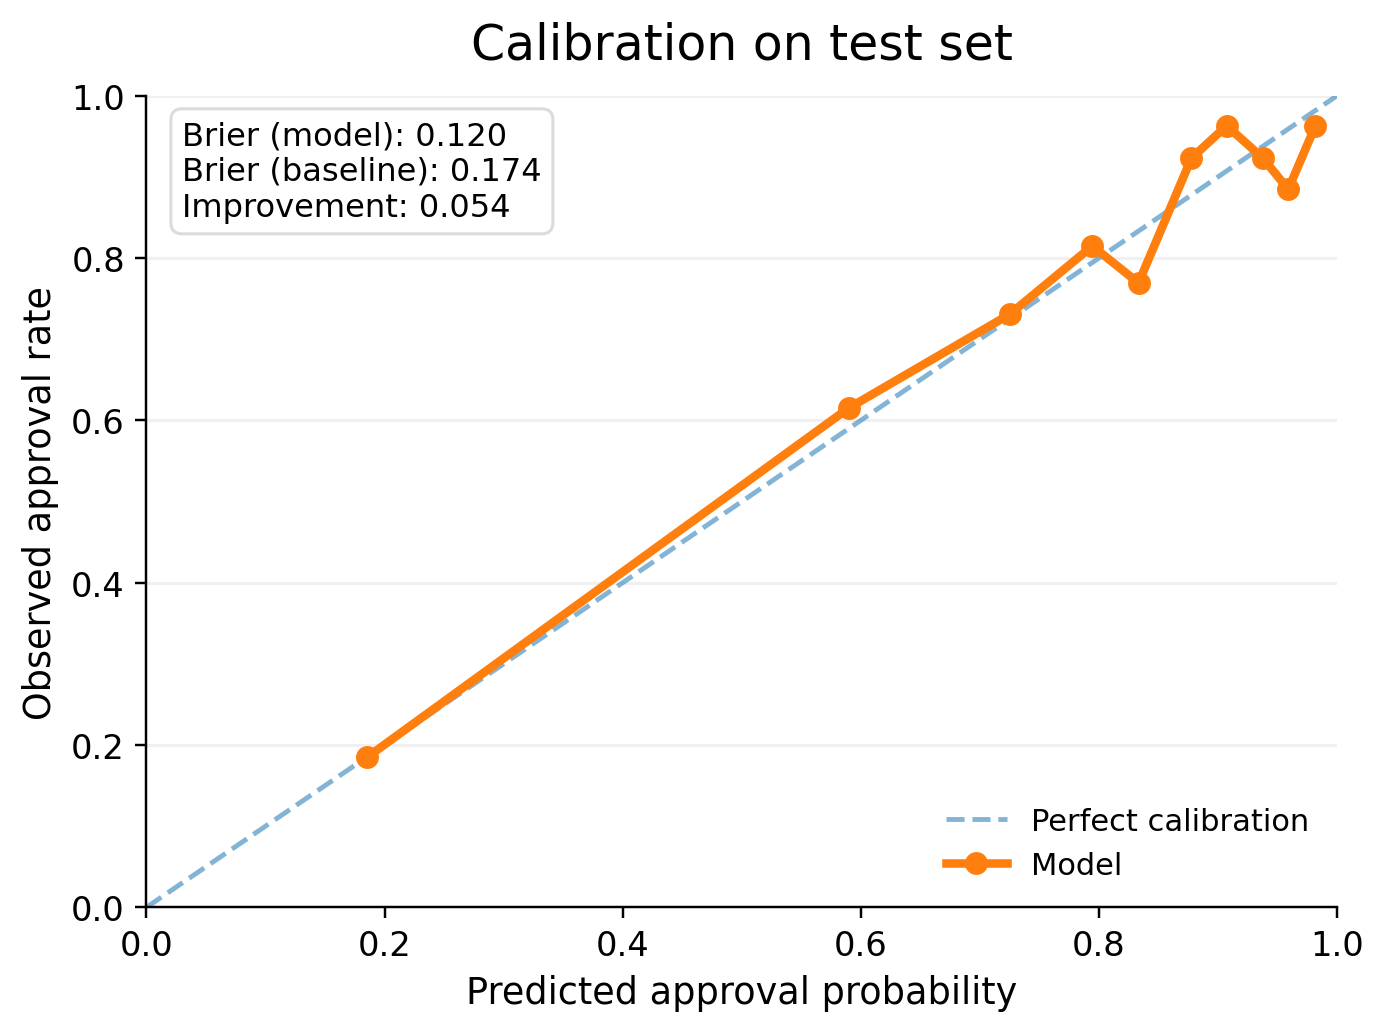


Stability over 20 stratified splits:
       roc_auc   pr_auc    brier
count  20.0000  20.0000  20.0000
mean    0.8316   0.9258   0.1148
std     0.0349   0.0228   0.0098
min     0.7582   0.8851   0.0951
10%     0.7963   0.9027   0.1043
50%     0.8267   0.9213   0.1145
90%     0.8760   0.9556   0.1278
max     0.8935   0.9658   0.1350

Slide summary (mean / p10 / p90):
 metric   mean    p10    p90
ROC AUC 0.8316 0.7963 0.8760
 PR AUC 0.9258 0.9027 0.9556
  Brier 0.1148 0.1043 0.1278


In [7]:
# 7) Model evaluation and stability analysis

# Brier score and baseline comparison
brier = brier_score_loss(y_te_main, p_te)
p_base = np.full_like(y_te_main, y_tr_main.mean(), dtype=float)
brier_base = brier_score_loss(y_te_main, p_base)

print(f"Brier (test): {brier:.4f}")
print(f"Prevalence train/test: {y_tr_main.mean():.3f}/{y_te_main.mean():.3f}")
print(f"Brier baseline/model/improvement: {brier_base:.4f} {brier:.4f} {(brier_base - brier):.4f}")

# Plot calibration curve to assess probability reliability
obs_rate, pred_prob = calibration_curve(y_te_main, p_te, n_bins=10, strategy="quantile")

fig, ax = plt.subplots(dpi=220)
ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1.6, alpha=0.55, label="Perfect calibration")
ax.plot(
    pred_prob, obs_rate,
    marker="o", markersize=6.5,
    linewidth=2.8,
    label="Model"
)

# Plot styling
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("Predicted approval probability", fontsize=12)
ax.set_ylabel("Observed approval rate", fontsize=12)
ax.set_title("Calibration on test set", fontsize=16, pad=12)
ax.tick_params(axis="both", labelsize=11)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, axis="y", alpha=0.18, linewidth=1)

# Add Brier metrics text box
txt = (
    f"Brier (model): {brier:.3f}\n"
    f"Brier (baseline): {brier_base:.3f}\n"
    f"Improvement: {brier_base - brier:.3f}"
)
ax.text(
    0.03, 0.97, txt,
    transform=ax.transAxes,
    va="top", ha="left",
    fontsize=10.5,
    bbox=dict(boxstyle="round,pad=0.35", facecolor="white", edgecolor="0.85", alpha=0.95)
)

ax.legend(frameon=False, fontsize=10, loc="lower right")
fig.tight_layout()
fig.savefig("calibration_test.png", bbox_inches="tight", dpi=300)
plt.show()

# Stability check via repeated stratified splits
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=RANDOM_STATE)

rows = []
for tr_i, te_i in sss.split(X_raw, y):
    Xr_tr, Xr_te = X_raw[tr_i], X_raw[te_i]
    y_tr_i, y_te_i = y[tr_i], y[te_i]

    # Standardize each split based on its own training set
    mu_i = Xr_tr.mean(axis=0)
    sd_i = Xr_tr.std(axis=0, ddof=0)
    sd_i = np.where(sd_i == 0, 1.0, sd_i)

    X_tr_i = np.column_stack([np.ones(len(Xr_tr)), (Xr_tr - mu_i) / sd_i])
    X_te_i = np.column_stack([np.ones(len(Xr_te)), (Xr_te - mu_i) / sd_i])

    # Fit and predict for each iteration
    b_i, _ = fit_logit_irls(X_tr_i, y_tr_i)
    p_i = sigmoid(X_te_i @ b_i)

    rows.append({
        "roc_auc": roc_auc_score(y_te_i, p_i),
        "pr_auc": average_precision_score(y_te_i, p_i),
        "brier": brier_score_loss(y_te_i, p_i),
    })

stab = pd.DataFrame(rows)

print("\nStability over 20 stratified splits:")
print(stab.describe(percentiles=[0.1, 0.5, 0.9]).round(4).to_string())

# Generate final summary table for reporting
stab_slide = pd.DataFrame({
    "metric": ["ROC AUC", "PR AUC", "Brier"],
    "mean":   [stab["roc_auc"].mean(), stab["pr_auc"].mean(), stab["brier"].mean()],
    "p10":    [stab["roc_auc"].quantile(0.10), stab["pr_auc"].quantile(0.10), stab["brier"].quantile(0.10)],
    "p90":    [stab["roc_auc"].quantile(0.90), stab["pr_auc"].quantile(0.90), stab["brier"].quantile(0.90)],
}).round(4)

print("\nSlide summary (mean / p10 / p90):")
print(stab_slide.to_string(index=False))

### Discriminative Power 
The ROC Curve and AUC provide a global view of the model's ability to separate approved from rejected cases.

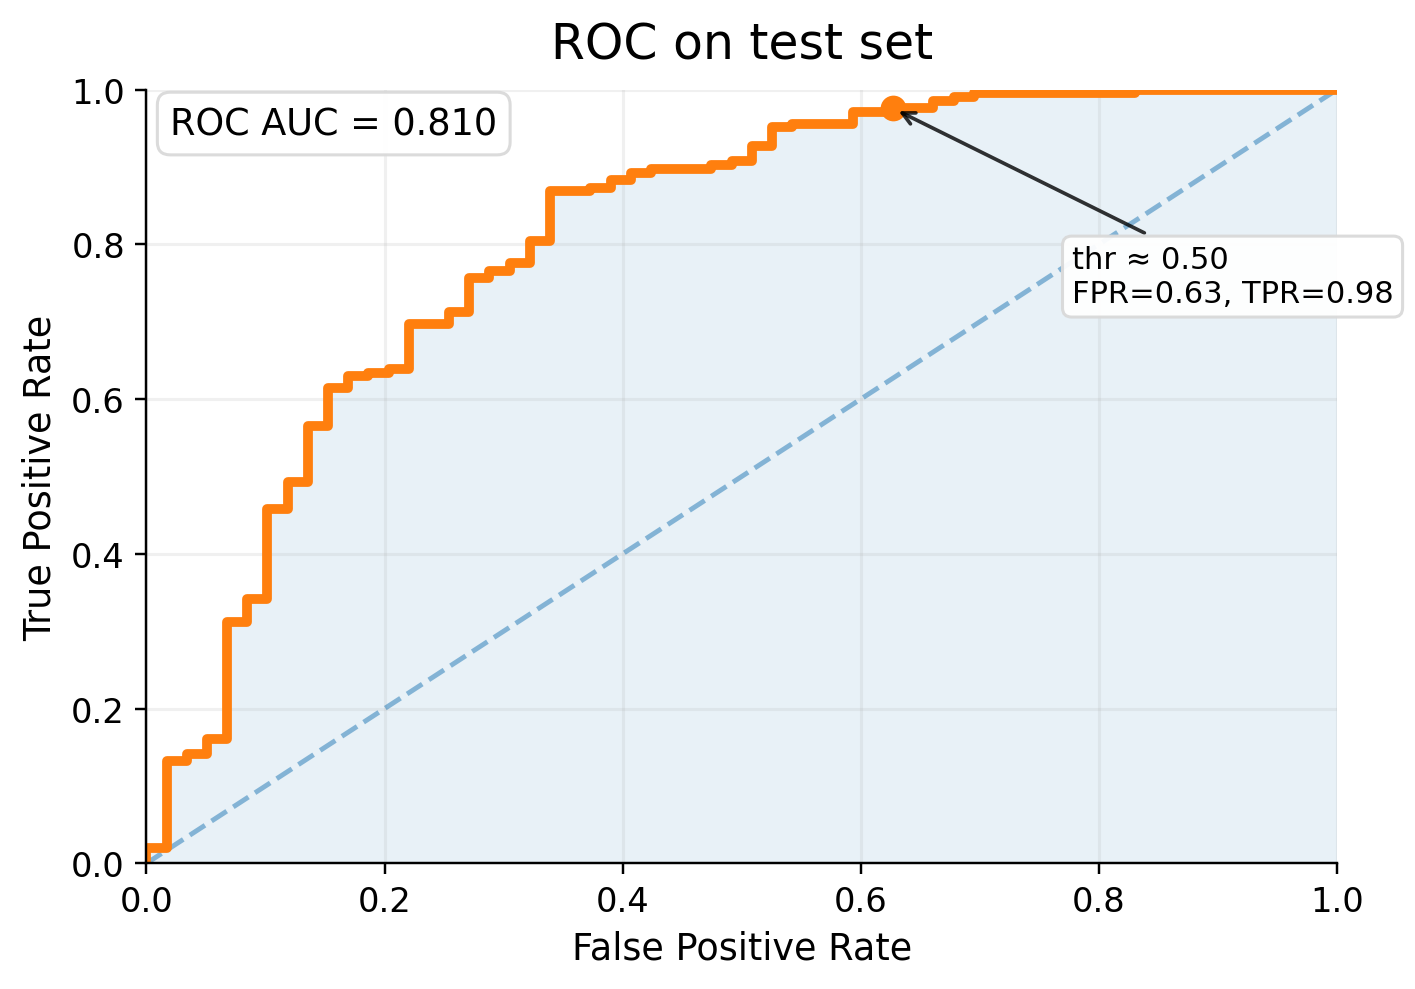

In [9]:
# 8) ROC Curve analysis
fpr, tpr, thr = roc_curve(y_te_main, p_te)
auc = roc_auc_score(y_te_main, p_te)

# Select an operating point (threshold ≈ 0.50) for the plot
t0 = 0.50
i0 = np.argmin(np.abs(thr - t0))

fig, ax = plt.subplots(figsize=(6.6, 4.6), dpi=220)

# Random baseline and ROC curve
ax.plot([0, 1], [0, 1], ls="--", lw=1.6, alpha=0.5)
ax.plot(fpr, tpr, lw=3.2)
ax.fill_between(fpr, tpr, 0, alpha=0.10)

# Highlight and annotate specific operating point
ax.scatter([fpr[i0]], [tpr[i0]], s=55, zorder=3)
ax.annotate(
    f"thr ≈ {thr[i0]:.2f}\nFPR={fpr[i0]:.2f}, TPR={tpr[i0]:.2f}",
    xy=(fpr[i0], tpr[i0]),
    xytext=(min(fpr[i0] + 0.15, 0.85), max(tpr[i0] - 0.25, 0.05)),
    fontsize=10,
    arrowprops=dict(arrowstyle="->", lw=1.2, alpha=0.8),
    bbox=dict(boxstyle="round,pad=0.30", fc="white", ec="0.85", alpha=0.95),
)

# Display AUC score in a dedicated text box
ax.text(
    0.02, 0.98, f"ROC AUC = {auc:.3f}",
    transform=ax.transAxes, va="top", ha="left",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="0.85", alpha=0.95)
)

# Labels and plot cosmetics
ax.set_title("ROC on test set", fontsize=16, pad=10)
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.grid(True, alpha=0.18, lw=1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(labelsize=11)

fig.tight_layout()
fig.savefig("roc_test.png", bbox_inches="tight", dpi=300)
plt.show()

## 5. Optimal Threshold Selection 
We search for the threshold that minimizes the total cost per 1,000 applications, considering the high cost of approving a risky applicant (False Positive).

In [11]:
# 9) Discrimination and policy selection
auc = roc_auc_score(y_te_main, p_te)
pr_auc = average_precision_score(y_te_main, p_te)
print(f"\nROC AUC (test): {auc:.4f} | PR AUC (test): {pr_auc:.4f}")

# Evaluation at default 0.50 threshold
yhat_ref = (p_te >= 0.50).astype(int)
print_cm(y_te_main, yhat_ref, title="Confusion matrix @ thr=0.50")
print("\nClassification report @ thr=0.50")
print(classification_report(y_te_main, yhat_ref, digits=3))

# Search for the optimal threshold based on asymmetric costs
tab, best = build_policy_table(y_te_main, p_te, thresholds=THRESHOLDS, cost_fp=COST_FP, cost_fn=COST_FN)
cols = ["thr","approval_rate","tn","fp","fn","tp","precision","recall","specificity","cost_per_1000"]
print("\nPolicy table (test):")
print(tab[cols].round(4).to_string(index=False))

print("\nBest threshold (min cost_per_1000):")
print({k: (round(v, 4) if isinstance(v, float) else v) for k, v in best.items()})

# Evaluation at the fixed business threshold
summarize_at_threshold(y_te_main, p_te, THR_BUSINESS)


ROC AUC (test): 0.8104 | PR AUC (test): 0.9146

Confusion matrix @ thr=0.50
       pred0  pred1
true0     22     37
true1      6    199

Classification report @ thr=0.50
              precision    recall  f1-score   support

           0      0.786     0.373     0.506        59
           1      0.843     0.971     0.902       205

    accuracy                          0.837       264
   macro avg      0.814     0.672     0.704       264
weighted avg      0.830     0.837     0.814       264


Policy table (test):
 thr  approval_rate  tn  fp  fn  tp  precision  recall  specificity  cost_per_1000
0.10         0.9545  11  48   1 204     0.8095  0.9951       0.1864       912.8788
0.15         0.9470  13  46   1 204     0.8160  0.9951       0.2203       875.0000
0.20         0.9356  16  43   1 204     0.8259  0.9951       0.2712       818.1818
0.25         0.9356  16  43   1 204     0.8259  0.9951       0.2712       818.1818
0.30         0.9318  17  42   1 204     0.8293  0.9951       0.28

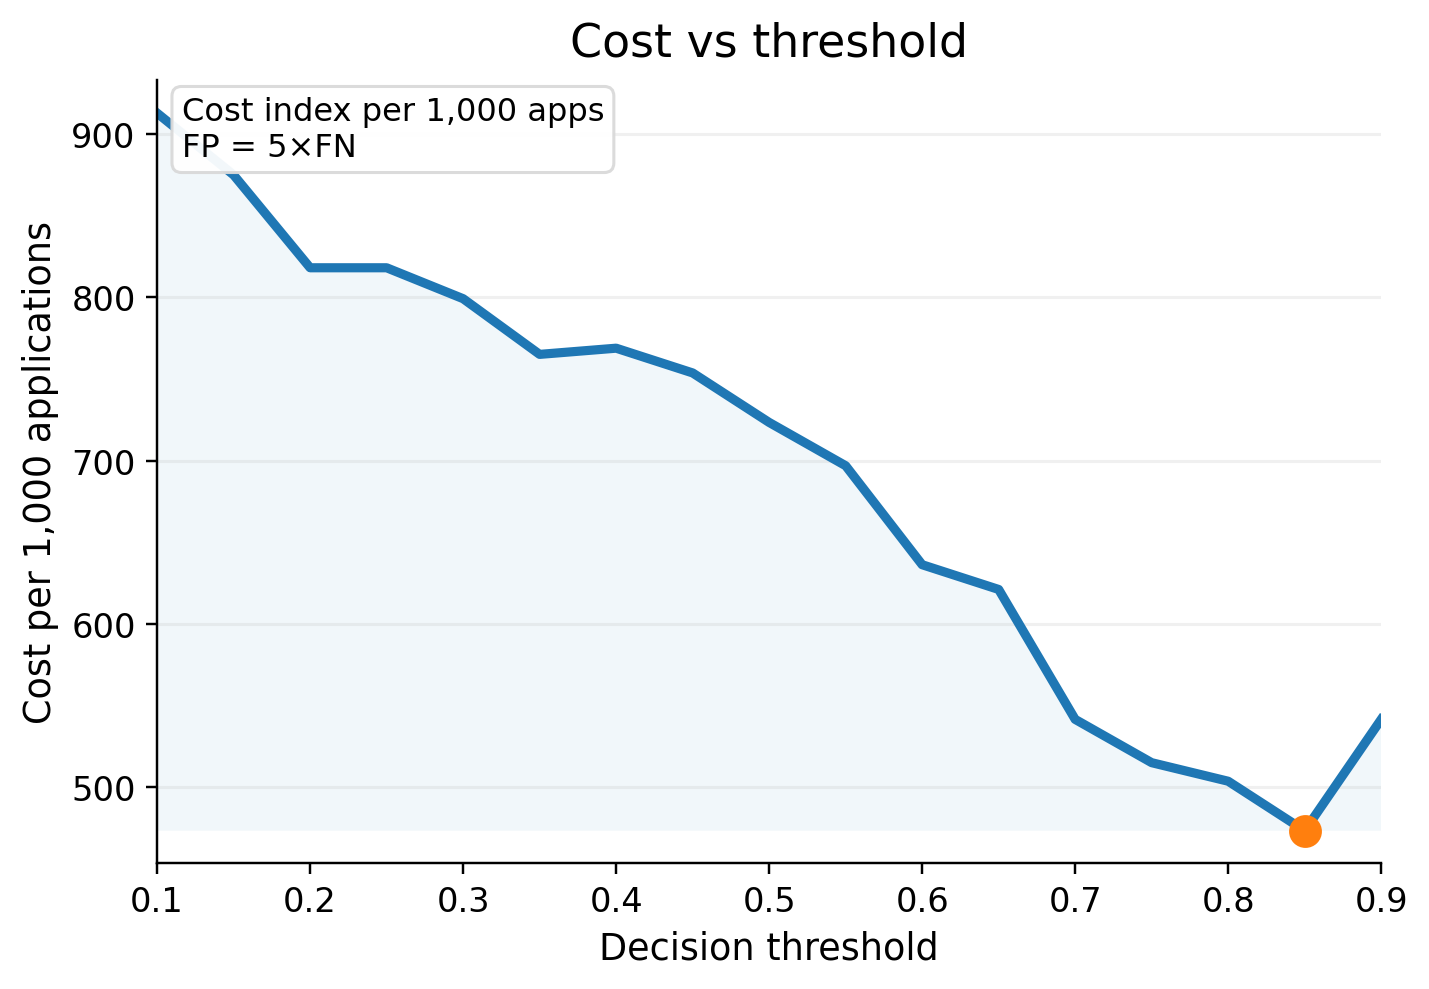

In [12]:
# 10) Visualization of cost optimization across thresholds
fig, ax = plt.subplots(figsize=(6.6, 4.6), dpi=220)

x = tab["thr"].to_numpy()
y = tab["cost_per_1000"].to_numpy()

# Plot the cost curve
ax.plot(x, y, linewidth=3.0)

# Add a subtle fill for better readability
ymin, ymax = float(y.min()), float(y.max())
ax.fill_between(x, y, ymin, alpha=0.06)

# Highlight the optimal threshold (minimum cost)
bx = float(best["thr"])
by = float(best["cost_per_1000"])
ax.scatter([bx], [by], s=95, zorder=3)

# Display the cost scenario configuration
ax.text(
    0.02, 0.98,
    "Cost index per 1,000 apps\nFP = 5×FN",
    transform=ax.transAxes,
    va="top", ha="left",
    fontsize=10.5,
    bbox=dict(boxstyle="round,pad=0.30", facecolor="white", edgecolor="0.85", alpha=0.95),
)

# Set labels and title
ax.set_title("Cost vs threshold", fontsize=15, pad=8)
ax.set_xlabel("Decision threshold", fontsize=12)
ax.set_ylabel("Cost per 1,000 applications", fontsize=12)

# Chart aesthetics and limits
ax.set_xlim(0.10, 0.90)
ax.set_ylim(ymin - 20, ymax + 20)

ax.grid(True, axis="y", alpha=0.18, linewidth=1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(labelsize=11)

fig.tight_layout()
fig.savefig("cost_vs_threshold.png", bbox_inches="tight", dpi=300)
plt.show()

In [13]:
# 11) Sensitivity analysis: Cost ratios impact on threshold selection
SCENARIOS = [("2:1", 2, 1), ("5:1", 5, 1), ("10:1", 10, 1)]
rows = []

# Evaluate specific business scenarios
for name, cfp, cfn in SCENARIOS:
    tab_s, best_s = build_policy_table(y_te_main, p_te, thresholds=THRESHOLDS, cost_fp=cfp, cost_fn=cfn)
    rows.append({
        "scenario": name,
        "best_thr": best_s["thr"],
        "approval_rate": best_s["approval_rate"],
        "fp": best_s["fp"],
        "fn": best_s["fn"],
        "cost_per_1000": best_s["cost_per_1000"],
    })

sens_discrete = pd.DataFrame(rows)
print("\nSensitivity (discrete scenarios):")
print(sens_discrete.round(4).to_string(index=False))

# Continuous sensitivity analysis across different FP/FN ratios
RATIOS = np.arange(1, 21)
rows = []

for r in RATIOS:
    tab_r, best_r = build_policy_table(
        y_te_main, p_te,
        thresholds=THRESHOLDS,
        cost_fp=r, cost_fn=1
    )
    rows.append({
        "fp_to_fn_ratio": r,
        "best_thr": best_r["thr"],
        "min_cost_per_1000": best_r["cost_per_1000"],
        "approval_rate": best_r["approval_rate"],
        "fp": best_r["fp"],
        "fn": best_r["fn"],
    })

sens_curve = pd.DataFrame(rows)
print("\nSensitivity curve (continuous ratios):")
print(sens_curve.to_string(index=False))


Sensitivity (discrete scenarios):
scenario  best_thr  approval_rate   fp   fn  cost_per_1000
     2:1      0.70         0.7803 24.0 23.0       268.9394
     5:1      0.85         0.5076  9.0 80.0       473.4848
    10:1      0.85         0.5076  9.0 80.0       643.9394

Sensitivity curve (continuous ratios):
 fp_to_fn_ratio  best_thr  min_cost_per_1000  approval_rate   fp    fn
              1      0.35         159.090909       0.920455 40.0   2.0
              2      0.70         268.939394       0.780303 24.0  23.0
              3      0.70         359.848485       0.780303 24.0  23.0
              4      0.75         439.393939       0.715909 20.0  36.0
              5      0.85         473.484848       0.507576  9.0  80.0
              6      0.85         507.575758       0.507576  9.0  80.0
              7      0.85         541.666667       0.507576  9.0  80.0
              8      0.85         575.757576       0.507576  9.0  80.0
              9      0.85         609.848485      

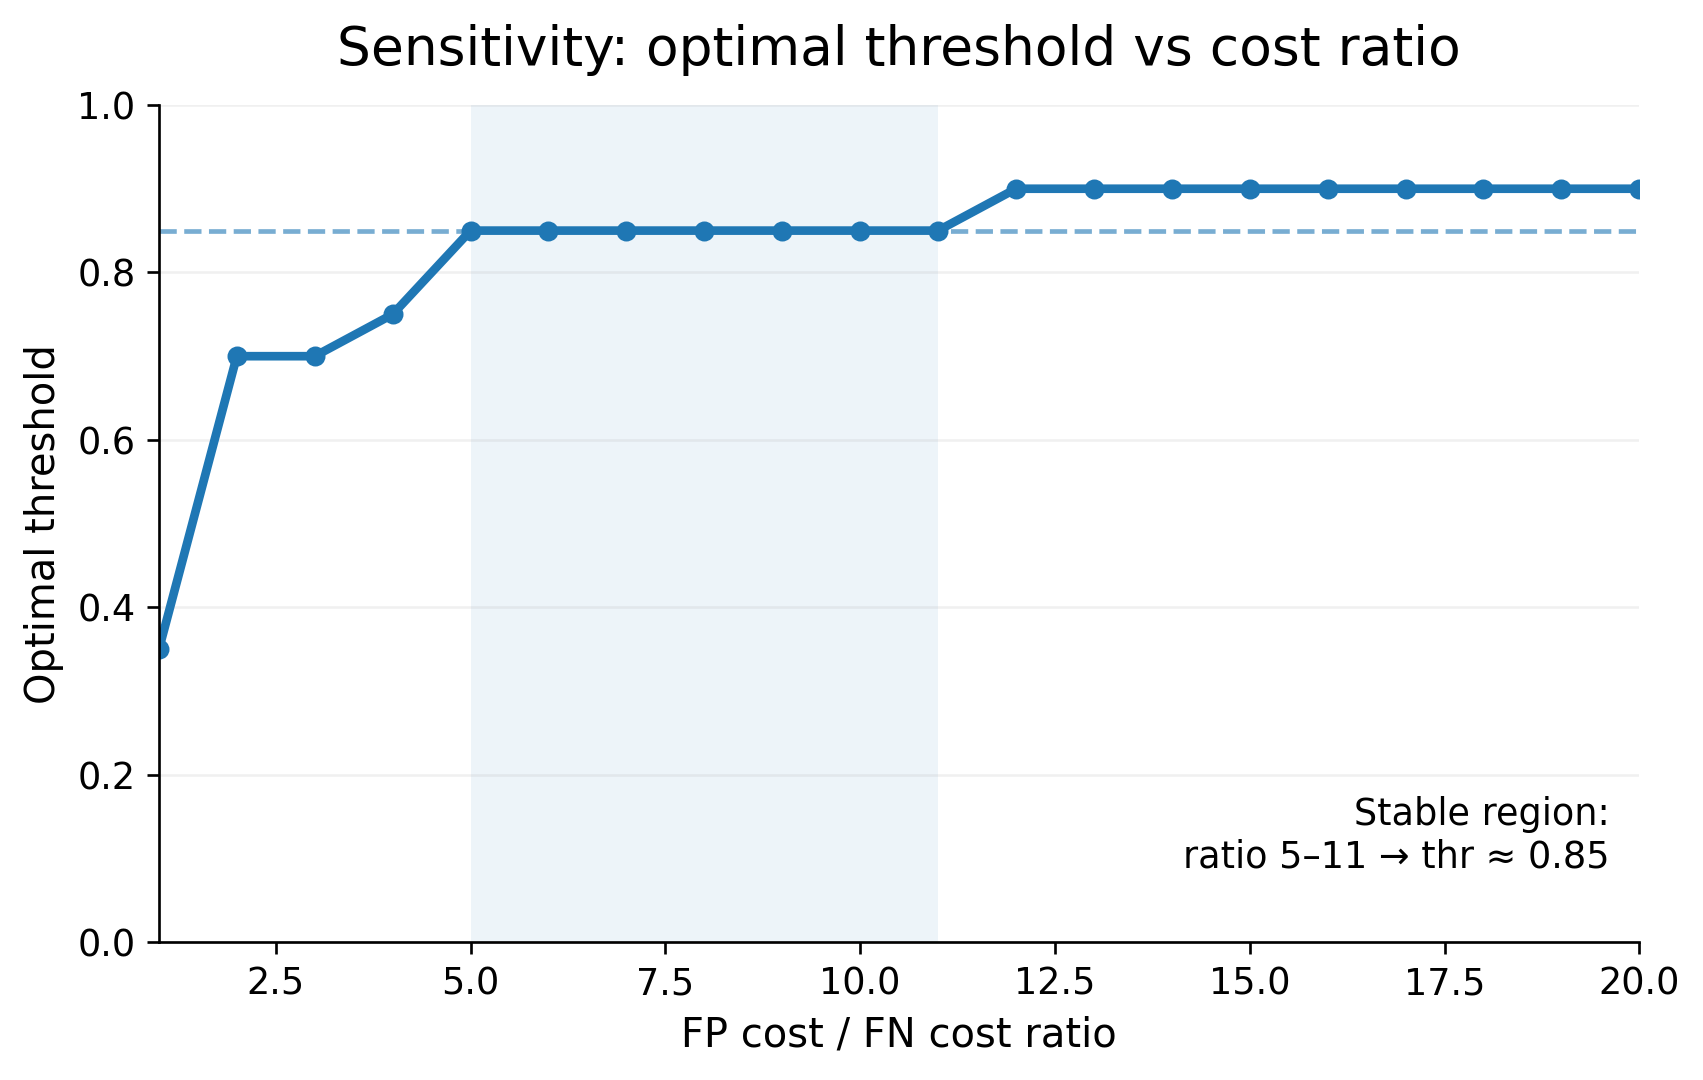

In [14]:
# 12) Sensitivity Plot: Optimal Threshold vs Cost Ratio
def style_ax(ax):
    """Utility function for consistent chart styling."""
    ax.grid(True, axis="y", alpha=0.18)
    ax.grid(False, axis="x")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="both", labelsize=11)

# Prepare data for plotting from sensitivity results
x = sens_curve["fp_to_fn_ratio"].to_numpy()
thr = sens_curve["best_thr"].to_numpy()
appr = sens_curve["approval_rate"].to_numpy()
cost = sens_curve["min_cost_per_1000"].to_numpy()

# Define the stable region parameters for highlighting
ROBUST_LO, ROBUST_HI = 5, 11
ROBUST_THR = 0.85

fig, ax = plt.subplots(figsize=(7.2, 4.6), dpi=240)

# Generate the main sensitivity curve
ax.plot(x, thr, marker="o", linewidth=2.6, markersize=5)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(0, 1)

# Highlight the plateau region to show policy stability
ax.axhline(ROBUST_THR, linestyle="--", linewidth=1.4, alpha=0.6)
ax.axvspan(ROBUST_LO, ROBUST_HI, alpha=0.08)

ax.set_xlabel("FP cost / FN cost ratio", fontsize=12)
ax.set_ylabel("Optimal threshold", fontsize=12)
ax.set_title("Sensitivity: optimal threshold vs cost ratio", fontsize=16, pad=12)

# Annotate the stable range findings
ax.text(
    0.98, 0.08,
    f"Stable region:\nratio {ROBUST_LO}–{ROBUST_HI} → thr ≈ {ROBUST_THR:.2f}",
    transform=ax.transAxes,
    ha="right", va="bottom",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.9)
)

style_ax(ax)
fig.tight_layout()
fig.savefig("sens_threshold_vs_ratio.png", bbox_inches="tight", dpi=300)
plt.show()

## 6. Advanced Triage: Three-Way Decision Policy 
We implement a policy that includes a 'Manual Review' band for borderline cases, allowing for human intervention where the model is least confident.

In [15]:
# 13) 3-way policy: Auto-approve, Manual review, and Decline
def three_band_policy(y_true, p, t_high, manual_share=0.10, cost_fp=COST_FP, cost_fn=COST_FN):
    """
    Implements a triage policy where a fixed % of borderline cases 
    are sent for manual review.
    """
    n = len(p)
    order = np.argsort(p)
    p_sorted = p[order]

    # Calculate number of cases for manual review
    k_manual = int(np.round(manual_share * n))

    # Define the high-confidence approval threshold index
    idx_high = np.where(p_sorted >= t_high)[0]
    start_high = int(idx_high[0]) if len(idx_high) else n

    # Define the manual review window immediately below the high threshold
    start_manual = max(0, start_high - k_manual)

    # Assign bands
    bands = np.empty(n, dtype=object)
    bands[order[:start_manual]] = "decline"
    bands[order[start_manual:start_high]] = "manual"
    bands[order[start_high:]] = "approve"

    def eval_manual_as(choice):
        """Helper to calculate business impact based on manual review outcomes."""
        if choice == "approve":
            yhat = ((bands == "approve") | (bands == "manual")).astype(int)
        elif choice == "decline":
            yhat = (bands == "approve").astype(int)
        else:
            raise ValueError("choice must be 'approve' or 'decline'")

        tn, fp, fn, tp = confusion_matrix(y_true, yhat).ravel()
        cost = cost_fp * fp + cost_fn * fn
        return {"tn": tn, "fp": fp, "fn": fn, "tp": tp, "cost_per_1000": 1000 * cost / n}

    # Calculate percentage share of each band
    shares = pd.Series(bands).value_counts(normalize=True).reindex(["approve","manual","decline"]).fillna(0)

    return {
        "t_high": t_high,
        "shares": shares,
        "manual_as_decline": eval_manual_as("decline"),
        "manual_as_approve": eval_manual_as("approve"),
        "bands": bands
    }

# Execute policy on test set using the business threshold
policy3 = three_band_policy(y_te_main, p_te, t_high=THR_BUSINESS, manual_share=0.10, cost_fp=COST_FP, cost_fn=COST_FN)

print("\n3-way policy:")
print("t_high (auto-approve):", policy3["t_high"])
print("Band shares:")
print((100 * policy3["shares"]).round(2).astype(str) + "%")

# Report bounds of uncertainty for the manual review band
print("\nImpact bounds (manual unresolved):")
print("Conservative (manual=decline):", policy3["manual_as_decline"])
print("Aggressive   (manual=approve):", policy3["manual_as_approve"])


3-way policy:
t_high (auto-approve): 0.85
Band shares:
approve    50.76%
manual      9.85%
decline    39.39%
Name: proportion, dtype: object

Impact bounds (manual unresolved):
Conservative (manual=decline): {'tn': np.int64(50), 'fp': np.int64(9), 'fn': np.int64(80), 'tp': np.int64(125), 'cost_per_1000': np.float64(473.4848484848485)}
Aggressive   (manual=approve): {'tn': np.int64(44), 'fp': np.int64(15), 'fn': np.int64(60), 'tp': np.int64(145), 'cost_per_1000': np.float64(511.3636363636364)}


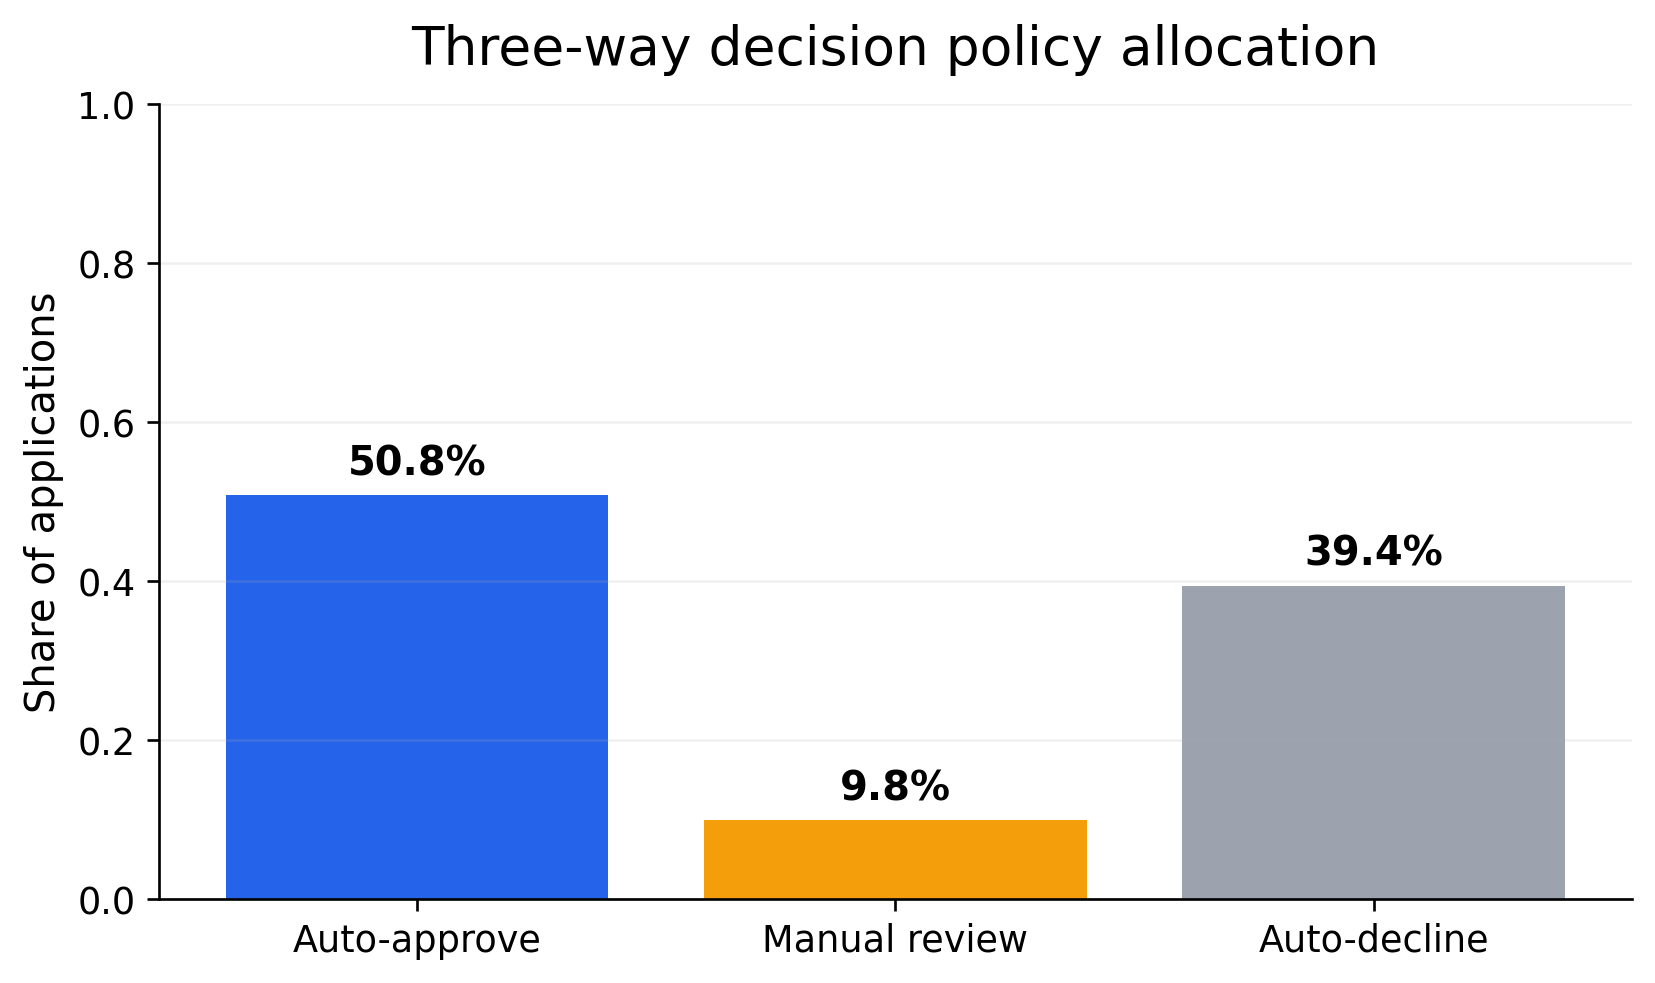

In [16]:
# 14) Visualization of the three-way decision policy allocation
labels = ["Auto-approve", "Manual review", "Auto-decline"]
values = [
    policy3["shares"].get("approve", 0.0),
    policy3["shares"].get("manual", 0.0),
    policy3["shares"].get("decline", 0.0),
]

colors = [
    "#2563EB", # blue
    "#F59E0B", # amber
    "#9CA3AF", # gray
]

fig, ax = plt.subplots(figsize=(7.0, 4.2), dpi=240)

# Create bar chart
bars = ax.bar(labels, values, color=colors)

# Configure axes and titles
ax.set_ylim(0, 1)
ax.set_ylabel("Share of applications", fontsize=12)
ax.set_title("Three-way decision policy allocation", fontsize=16, pad=12)

# Chart aesthetics
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, axis="y", alpha=0.18)
ax.grid(False, axis="x")
ax.tick_params(axis="both", labelsize=11)

# Add percentage labels on top of each bar
for bar, v in zip(bars, values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        v + 0.015,
        f"{v:.1%}",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold"
    )

fig.tight_layout()
fig.savefig("three_way_policy_allocation.png", bbox_inches="tight", dpi=300)
plt.show()

## 7. Segment Sensitivity Analysis 
Evaluating how the optimal policy shifts across different applicant profiles, such as credit history (reports) and income levels.

In [17]:
# 15) Segment-specific policy analysis
df_te = df.iloc[idx_te].copy()
df_te["y"] = y_te_main
df_te["p"] = p_te

def segment_best_policy(df_seg, name, thresholds=THRESHOLDS, cost_fp=COST_FP, cost_fn=COST_FN):
    """Calculate the optimal threshold for a specific data segment."""
    y_seg = df_seg["y"].to_numpy()
    p_seg = df_seg["p"].to_numpy()
    tab_s, best_s = build_policy_table(y_seg, p_seg, thresholds=thresholds, cost_fp=cost_fp, cost_fn=cost_fn)
    return {
        "segment": name,
        "n": len(df_seg),
        "rate": y_seg.mean(),
        "best_thr": best_s["thr"],
        "approval_rate": best_s["approval_rate"],
        "fp": best_s["fp"], "fn": best_s["fn"],
        "cost_per_1000": best_s["cost_per_1000"]
    }

# Analyze policy performance by number of derogatory reports
seg_rep0 = segment_best_policy(df_te[df_te["reports"] == 0], "reports=0")
seg_rep1 = segment_best_policy(df_te[df_te["reports"] > 0], "reports>0")

# Analyze policy performance by income levels (relative to training median)
med_income_tr = df.loc[idx_tr, "income"].median()
seg_inc_lo = segment_best_policy(df_te[df_te["income"] <= med_income_tr], "income<=median(train)")
seg_inc_hi = segment_best_policy(df_te[df_te["income"] >  med_income_tr], "income>median(train)")

# Compile and display the segment policy summary
seg_table = pd.DataFrame([seg_rep0, seg_rep1, seg_inc_lo, seg_inc_hi])
print("\nSegment policy summary:")
print(seg_table.round(4).to_string(index=False))


Segment policy summary:
              segment   n   rate  best_thr  approval_rate  fp   fn  cost_per_1000
            reports=0 210 0.8667      0.85         0.6143 9.0 62.0       509.5238
            reports>0  54 0.4259      0.80         0.1296 0.0 16.0       296.2963
income<=median(train) 131 0.7405      0.85         0.3664 2.0 51.0       465.6489
 income>median(train) 133 0.8120      0.85         0.6466 7.0 29.0       481.2030


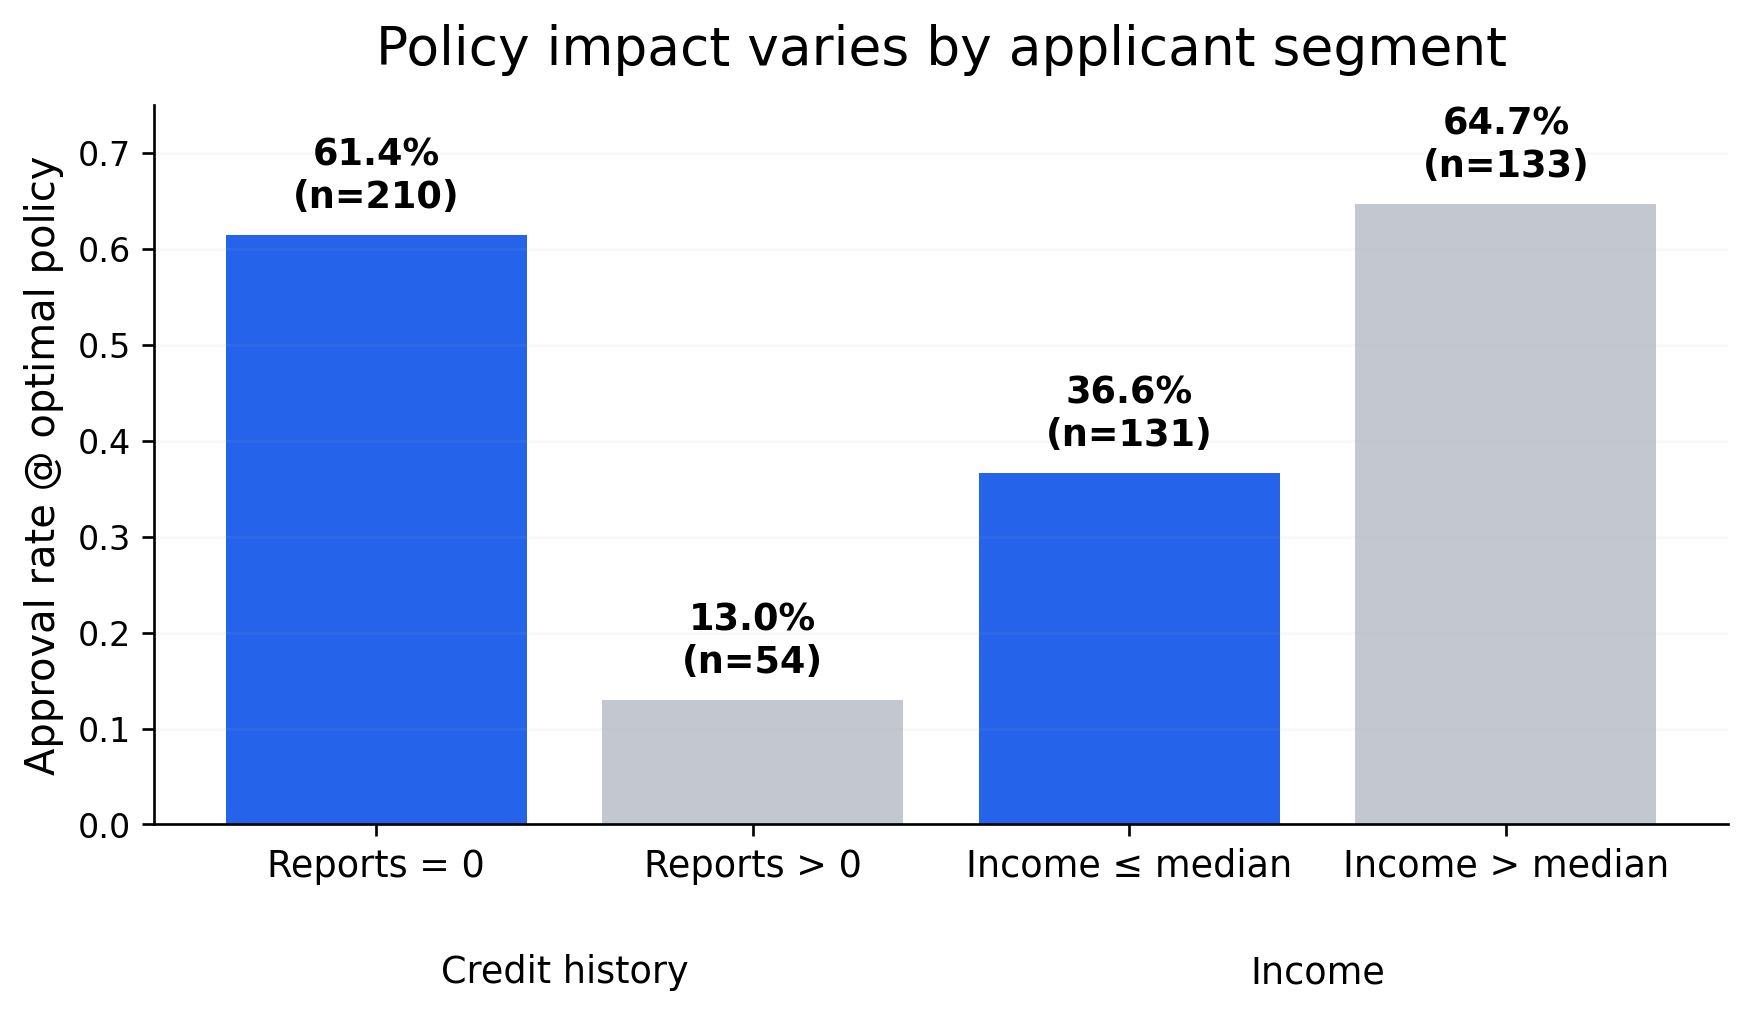

In [18]:
# 16) Visualization of approval rates across segments
order = ["reports=0", "reports>0", "income<=median(train)", "income>median(train)"]

# Reindex segment table for consistent plotting order
plot_df = (
    seg_table.set_index("segment")
    .reindex(order)
)

# Validate that all segments are present
missing = plot_df["approval_rate"].isna()
if missing.any():
    print("Missing segments in seg_table:", plot_df.loc[missing, "segment"].tolist())
    print("Available segments:", seg_table["segment"].tolist())
    raise ValueError("Update `order` to match your exact seg_table['segment'] values.")

labels = ["Reports = 0", "Reports > 0", "Income ≤ median", "Income > median"]
vals = plot_df["approval_rate"].to_numpy()
ns = plot_df["n"].to_numpy()

# Initialize plot
fig, ax = plt.subplots(figsize=(7.4, 4.4), dpi=240)

x = np.arange(len(vals))
colors = ["#2563EB", "#9CA3AF", "#2563EB", "#9CA3AF"]
alphas = [1.0, 0.6, 1.0, 0.6]

# Create bars with specific styles for each segment
bars = []
for i in range(len(x)):
    bar = ax.bar(
        x[i],
        vals[i],
        color=colors[i],
        alpha=alphas[i],
        edgecolor="none"
    )
    bars.append(bar)

# Axes and labels
ax.set_ylim(0, max(0.75, vals.max() + 0.10))
ax.set_ylabel("Approval rate @ optimal policy", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)

# Group labels on the x-axis
ax.text(0.5, -0.18, "Credit history", ha="center", va="top",
        transform=ax.get_xaxis_transform(), fontsize=11)
ax.text(2.5, -0.18, "Income", ha="center", va="top",
        transform=ax.get_xaxis_transform(), fontsize=11)

ax.set_title("Policy impact varies by applicant segment", fontsize=16, pad=12)

# Aesthetic cleanup
ax.grid(True, axis="y", alpha=0.08, linewidth=0.8)
ax.grid(False, axis="x")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add value and sample size labels on top of bars
for i, (v, n) in enumerate(zip(vals, ns)):
    ax.text(
        i, v + 0.02,
        f"{v:.1%}\n(n={int(n)})",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold"
    )

fig.tight_layout()
fig.savefig("segment_approval_rates.png", bbox_inches="tight", dpi=300)
plt.show()

## 8. Benchmark Comparison 
Finally, we compare our ML model against simple rule-based heuristics to quantify the economic value added by the predictive model.

In [19]:
# 17) Benchmark: Comparison with rule-based baselines
df_te = df.iloc[idx_te].copy()
df_te["y"] = y_te_main
df_te["p_model"] = p_te

def eval_yhat_policy(y_true, yhat, cost_fp=COST_FP, cost_fn=COST_FN):
    """Evaluate binary policy metrics and business costs."""
    tn, fp, fn, tp = confusion_matrix(y_true, yhat).ravel()
    
    # Calculate operating metrics
    approval_rate = yhat.mean()
    precision = tp/(tp+fp) if (tp+fp) else np.nan
    recall    = tp/(tp+fn) if (tp+fn) else np.nan
    spec      = tn/(tn+fp) if (tn+fp) else np.nan
    
    # Calculate cost normalized per 1,000 applications
    cost = cost_fp*fp + cost_fn*fn
    cost_per_1000 = 1000*cost/len(y_true)

    return {
        "approval_rate": approval_rate,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        "precision": precision, "recall": recall, "specificity": spec,
        "cost_per_1000": cost_per_1000
    }

# Model predictions at the chosen business threshold
yhat_model = (df_te["p_model"].to_numpy() >= THR_BUSINESS).astype(int)

# Define heuristic rules as baselines
yhat_r1 = (df_te["reports"].to_numpy() == 0).astype(int)

income_median_train = df.loc[idx_tr, "income"].median()
yhat_r2 = (df_te["income"].to_numpy() > income_median_train).astype(int)

yhat_r3 = ((df_te["reports"].to_numpy() == 0) &
           (df_te["income"].to_numpy() > income_median_train)).astype(int)

# Compare model against simple rules
rows = [
    {"policy": f"Model (thr={THR_BUSINESS:.2f})", **eval_yhat_policy(df_te["y"].to_numpy(), yhat_model)},
    {"policy": "Rule: approve if reports==0", **eval_yhat_policy(df_te["y"].to_numpy(), yhat_r1)},
    {"policy": "Rule: approve if income>median(train)", **eval_yhat_policy(df_te["y"].to_numpy(), yhat_r2)},
    {"policy": "Rule: reports==0 AND income>median(train)", **eval_yhat_policy(df_te["y"].to_numpy(), yhat_r3)},
]

bench = pd.DataFrame(rows)[["policy","approval_rate","tn","fp","fn","tp","precision","recall","specificity","cost_per_1000"]]
print("\nRules-based benchmark:")
print(bench.round(4).to_string(index=False))

# Format results for presentation/reporting
N = len(df_te)
bench_slide = bench.copy()
bench_slide["fp_per_1000"] = (bench_slide["fp"] / N * 1000).round(1)
bench_slide["fn_per_1000"] = (bench_slide["fn"] / N * 1000).round(1)

print("\nBenchmark (slide-friendly):")
print(bench_slide[["policy","approval_rate","fp_per_1000","fn_per_1000","cost_per_1000"]].round(2).to_string(index=False))


Rules-based benchmark:
                                   policy  approval_rate  tn  fp  fn  tp  precision  recall  specificity  cost_per_1000
                         Model (thr=0.85)         0.5076  50   9  80 125     0.9328  0.6098       0.8475       473.4848
              Rule: approve if reports==0         0.7955  31  28  23 182     0.8667  0.8878       0.5254       617.4242
    Rule: approve if income>median(train)         0.5038  34  25  97 108     0.8120  0.5268       0.5763       840.9091
Rule: reports==0 AND income>median(train)         0.3939  48  11 112  93     0.8942  0.4537       0.8136       632.5758

Benchmark (slide-friendly):
                                   policy  approval_rate  fp_per_1000  fn_per_1000  cost_per_1000
                         Model (thr=0.85)           0.51         34.1        303.0         473.48
              Rule: approve if reports==0           0.80        106.1         87.1         617.42
    Rule: approve if income>median(train)           0

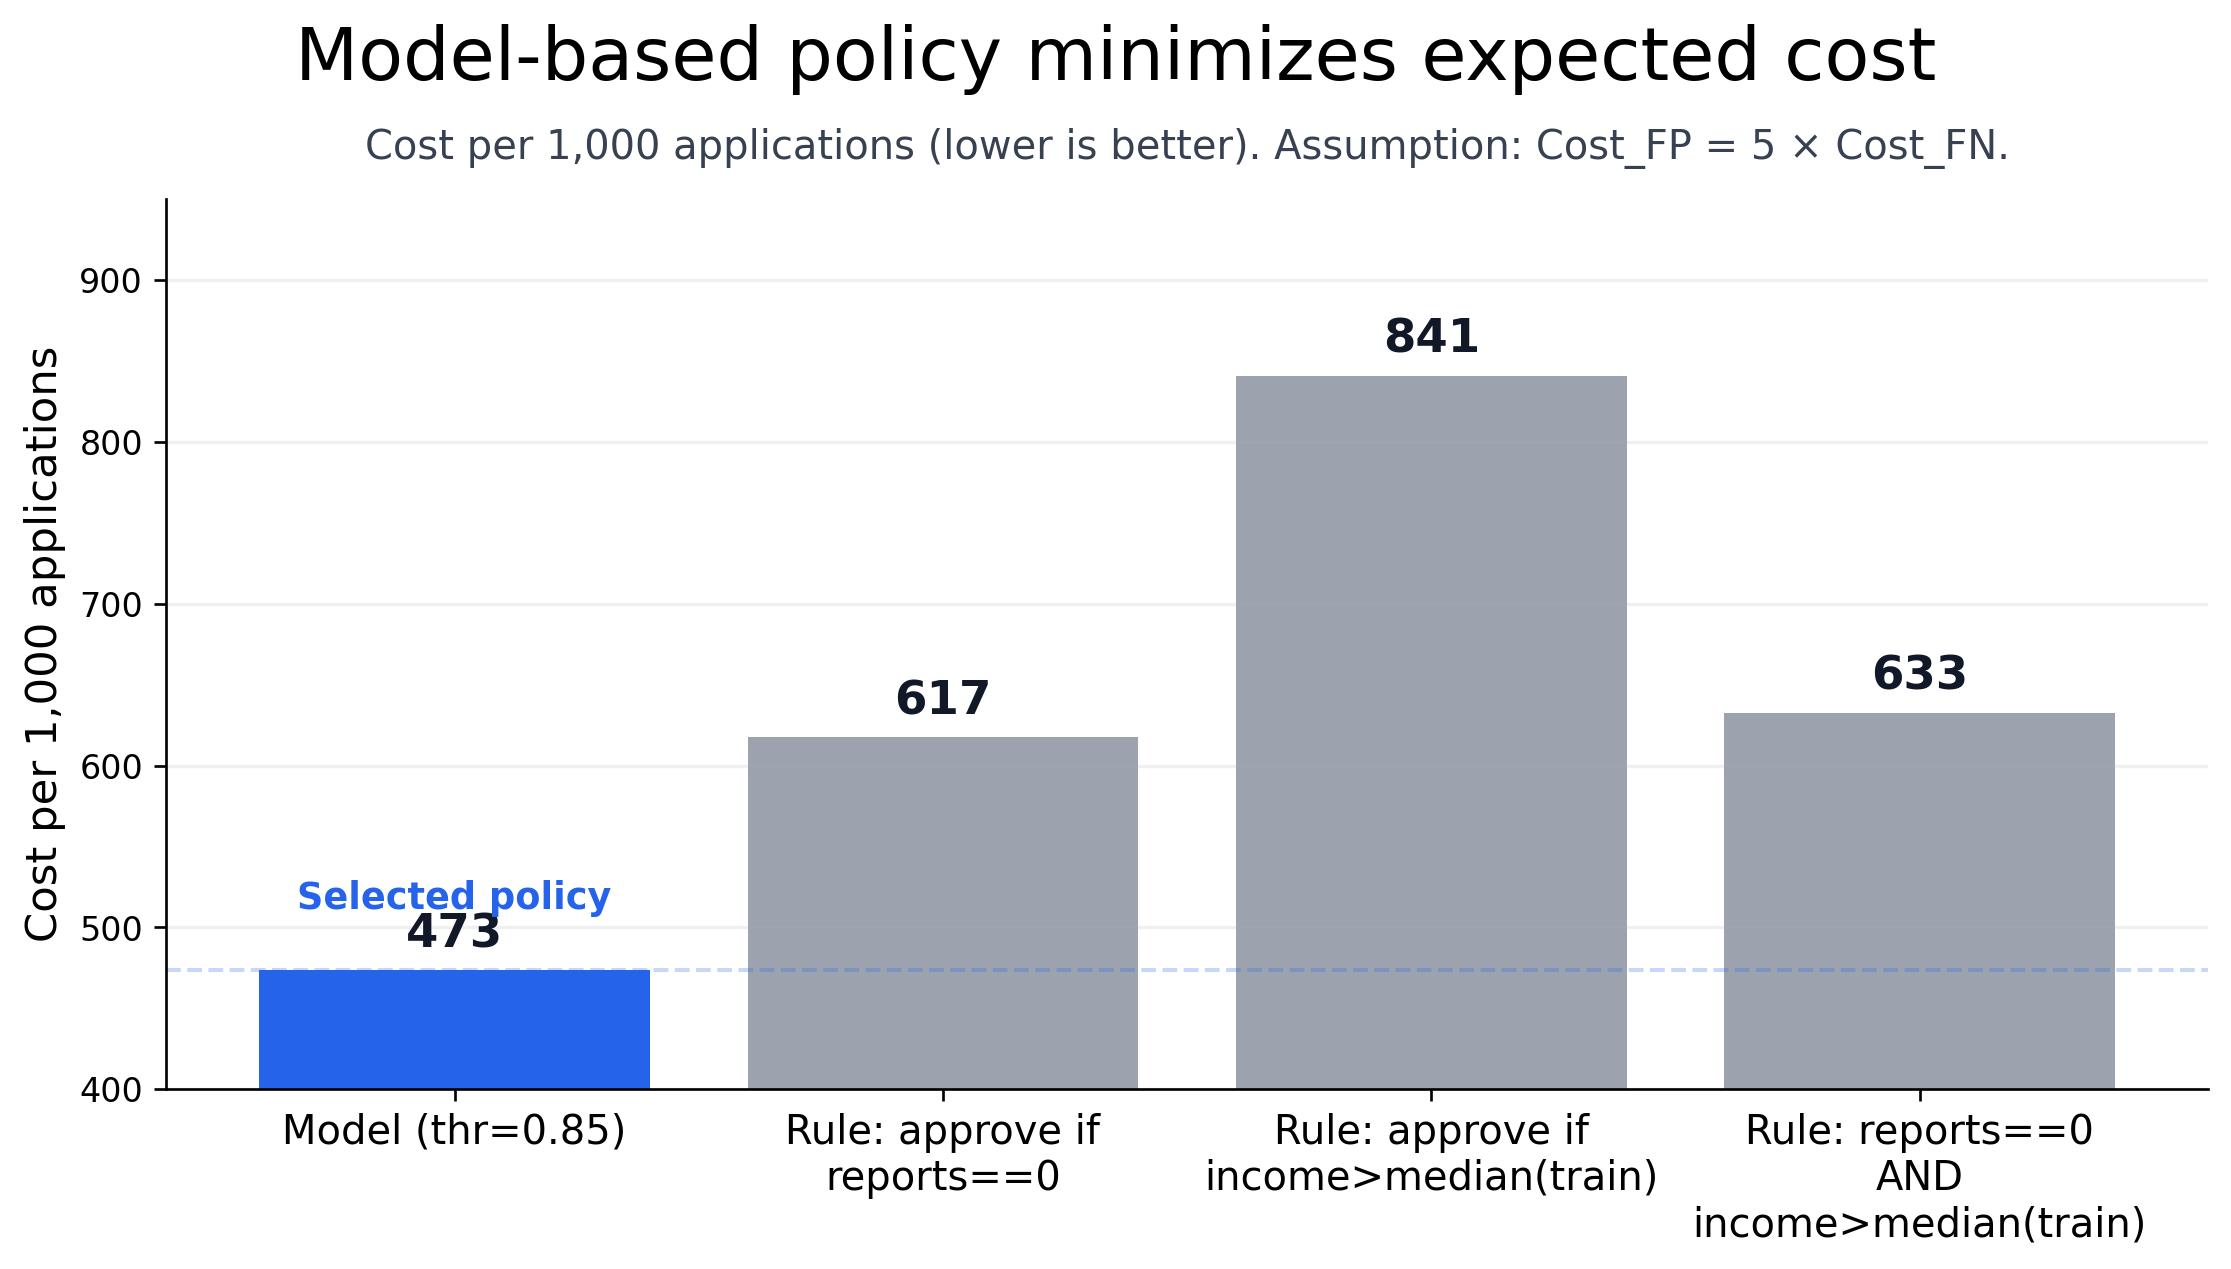

In [20]:
# 18) Final Benchmark Visualization: Cost Comparison
def wrap_labels(labels, width=18):
    """Utility to wrap long labels for better plot readability."""
    out = []
    for s in labels:
        words = str(s).split()
        line, lines = "", []
        for w in words:
            if len(line) + len(w) + (1 if line else 0) <= width:
                line = (line + " " + w).strip()
            else:
                lines.append(line)
                line = w
        if line:
            lines.append(line)
        out.append("\n".join(lines))
    return out

# Prepare data and ensure the Model is the first entry for highlighting
plot_df = bench_slide[["policy", "cost_per_1000"]].copy()
plot_df["cost_per_1000"] = plot_df["cost_per_1000"].astype(float)

model_mask = plot_df["policy"].str.contains("Model", case=False, na=False)
plot_df = pd.concat([plot_df[model_mask], plot_df[~model_mask]], ignore_index=True)

labels_raw = plot_df["policy"].tolist()
labels = wrap_labels(labels_raw, width=18)
vals = plot_df["cost_per_1000"].to_numpy()

# Colors: highlight the ML model (blue) vs rules (gray)
colors = ["#2563EB" if i == 0 else "#9CA3AF" for i in range(len(vals))]

# Initialize presentation-ready plot
fig, ax = plt.subplots(figsize=(9.4, 5.4), dpi=240)

bars = ax.bar(
    np.arange(len(vals)),
    vals,
    color=colors,
    edgecolor="none"
)

# Titles and context
fig.suptitle("Model-based policy minimizes expected cost", fontsize=22, y=0.97)
ax.set_title(
    "Cost per 1,000 applications (lower is better). Assumption: Cost_FP = 5 × Cost_FN.",
    fontsize=12, pad=12, color="#374151"
)

ax.set_ylabel("Cost per 1,000 applications", fontsize=13)
ax.set_xticks(np.arange(len(vals)))
ax.set_xticklabels(labels, fontsize=12)

# Aesthetic adjustments
ax.grid(True, axis="y", alpha=0.18, linewidth=1)
ax.grid(False, axis="x")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Dynamic axis scaling
ymin = max(0, np.floor(vals.min() * 0.85 / 50) * 50)
ymax = np.ceil(vals.max() * 1.10 / 50) * 50
ax.set_ylim(ymin, ymax)

# Add numerical annotations to bars
for rect, v in zip(bars, vals):
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        rect.get_height() + (ymax - ymin) * 0.015,
        f"{v:.0f}",
        ha="center", va="bottom",
        fontsize=14, fontweight="bold", color="#111827"
    )

# Add a reference line for the selected model policy
model_cost = vals[0]
ax.axhline(model_cost, linestyle="--", linewidth=1.2, alpha=0.25, color="#2563EB")
ax.text(
    0, model_cost + (ymax - ymin) * 0.06,
    "Selected policy",
    ha="center", va="bottom", fontsize=11, color="#2563EB", fontweight="bold"
)

fig.subplots_adjust(top=0.86)
fig.tight_layout()
fig.savefig("benchmark_cost_per_1000.png", bbox_inches="tight", dpi=300)
plt.show()

# Appendix

Acceptance rate: 0.278

MLE vs Bayes (key vars):
    var  mle_beta  mle_lo  mle_hi  bayes_beta  bayes_lo  bayes_hi  OR_mle  OR_bayes
reports    -2.432  -2.870  -1.995      -2.472    -2.934    -2.023   0.088     0.084
 income     0.395   0.154   0.635       0.404     0.172     0.648   1.484     1.498
 active     0.797   0.536   1.057       0.801     0.543     1.064   2.218     2.228


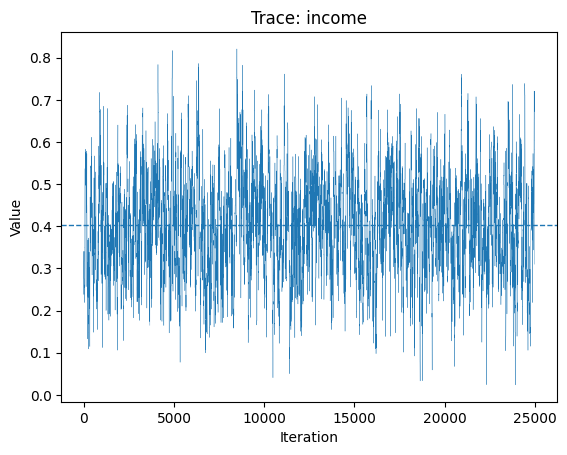

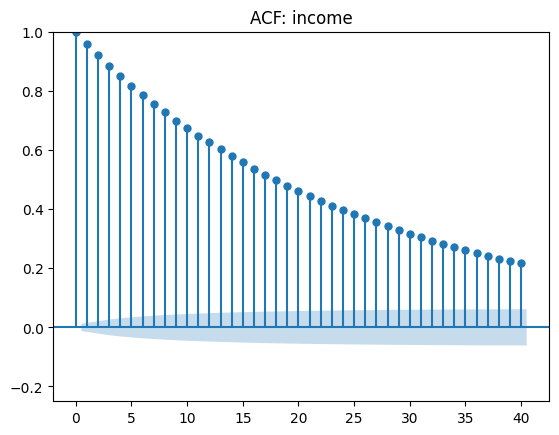

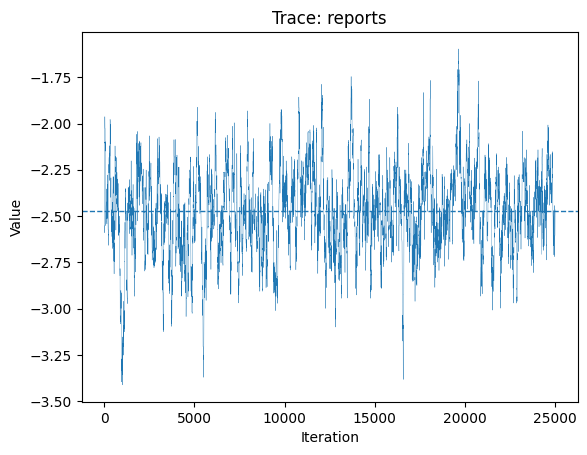

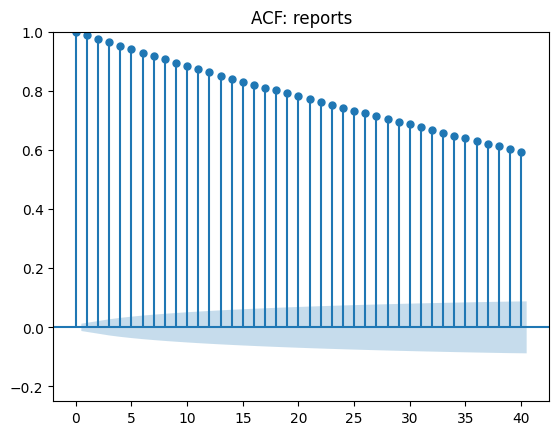

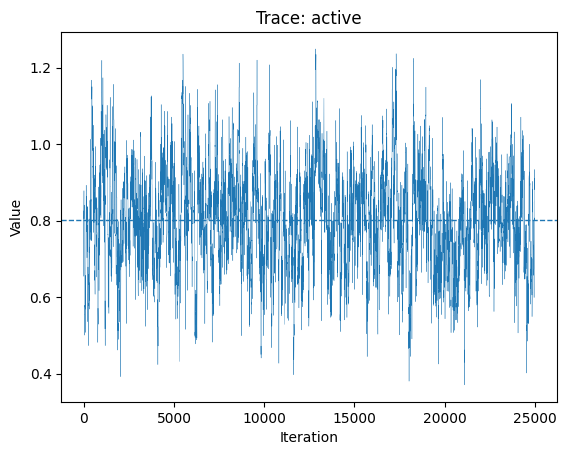

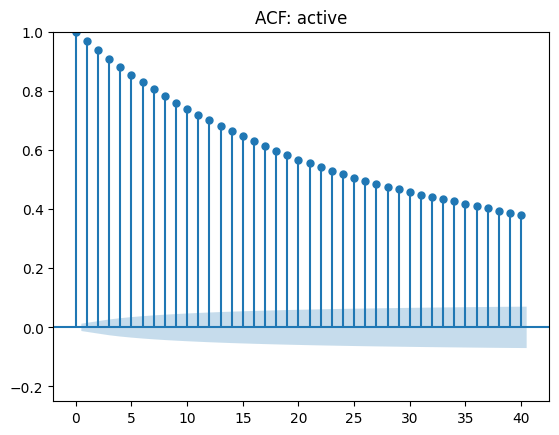

In [21]:
# Appendix — Bayesian check (Metropolis-Hastings for Logit)


def logpost_logit(beta: np.ndarray, X: np.ndarray, y: np.ndarray, prior_var: float = 100.0) -> float:
    """Log posterior = log-likelihood (Bernoulli logit) + N(0, prior_var I) prior."""
    eta = X @ beta
    loglik = np.sum(y * eta - np.logaddexp(0, eta))   # stable
    logprior = -0.5 * np.sum(beta**2) / prior_var
    return float(loglik + logprior)

def run_mh_logit(
    X: np.ndarray,
    y: np.ndarray,
    beta_init: np.ndarray,
    n_iter: int = 30000,
    burnin: int = 5000,
    step: float = 0.07,
    prior_var: float = 100.0,
    random_state: int = 22
):
    """Random-walk Metropolis for logistic regression coefficients."""
    rng = np.random.default_rng(random_state)
    p = X.shape[1]

    chain = np.zeros((n_iter, p))
    beta = beta_init.copy()

    lp = logpost_logit(beta, X, y, prior_var=prior_var)
    chain[0] = beta

    accepted = 0
    for i in range(1, n_iter):
        prop = beta + rng.normal(0, step, size=p)
        lp_prop = logpost_logit(prop, X, y, prior_var=prior_var)

        if np.log(rng.uniform()) <= (lp_prop - lp):
            beta, lp = prop, lp_prop
            accepted += 1

        chain[i] = beta

    post = chain[burnin:]
    acc_rate = accepted / (n_iter - 1)
    return post, acc_rate

# Run MCMC (start at MLE)
N_ITER = 30000
BURNIN = 5000
STEP = 0.07
PRIOR_VAR = 100.0

beta_init = b_hat.reshape(-1)
post, acc = run_mh_logit(
    X_tr_main, y_tr_main.astype(float),
    beta_init=beta_init,
    n_iter=N_ITER, burnin=BURNIN, step=STEP, prior_var=PRIOR_VAR,
    random_state=RANDOM_STATE
)

print(f"Acceptance rate: {acc:.3f}")
if acc < 0.15:
    print("Warning: acceptance is low → try smaller STEP (e.g., 0.05).")
elif acc > 0.5:
    print("Warning: acceptance is high → chain may mix slowly → try larger STEP (e.g., 0.10).")

# Posterior summaries
post_mean = post.mean(axis=0)
post_ci_lo = np.percentile(post, 2.5, axis=0)
post_ci_hi = np.percentile(post, 97.5, axis=0)

bayes = pd.DataFrame({
    "bayes_mean": post_mean,
    "bayes_lo": post_ci_lo,
    "bayes_hi": post_ci_hi
}, index=covariate_names)

# Compare on key drivers (use mle table computed earlier)
key_vars = ["reports", "income", "active"]
rows = []
for v in key_vars:
    rows.append({
        "var": v,
        "mle_beta": float(mle.loc[v, "beta"]),
        "mle_lo": float(mle.loc[v, "lo"]),
        "mle_hi": float(mle.loc[v, "hi"]),
        "bayes_beta": float(bayes.loc[v, "bayes_mean"]),
        "bayes_lo": float(bayes.loc[v, "bayes_lo"]),
        "bayes_hi": float(bayes.loc[v, "bayes_hi"]),
        "OR_mle": float(np.exp(mle.loc[v, "beta"])),
        "OR_bayes": float(np.exp(bayes.loc[v, "bayes_mean"])),
    })

cmp = pd.DataFrame(rows)
print("\nMLE vs Bayes (key vars):")
print(cmp.round(3).to_string(index=False))

# Diagnostics: trace + ACF
def mcmc_diag(var: str, post: np.ndarray, names: list[str], lags: int = 40):
    j = names.index(var)
    s = post[:, j]
    m = s.mean()

    plt.figure()
    plt.plot(s, linewidth=0.25)
    plt.axhline(m, linestyle="--", linewidth=1)
    plt.title(f"Trace: {var}")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.show()

    fig = sm.graphics.tsa.plot_acf(s, lags=lags)
    ax = fig.axes[0]
    ax.set_ylim(-0.25, 1.0)
    ax.set_title(f"ACF: {var}")
    plt.show()

for v in ["income", "reports", "active"]:
    mcmc_diag(v, post, covariate_names, lags=40)